# 4.1 Task 1: Safe Grid World Environment Setup
Begin by implementing the safe grid-world environment from scratch. The environment must support standard gym-like methods: reset() returns the initial state, step(action) executes an action and returns the next state, reward, and done flag, and render() visualises the current state. You must use the following exact configuration to ensure consistency across all student submissions:

## Environment Configuration:
• Grid size: 10 × 10
• Start position: (0, 0) (top-left corner)
• Goal position: (9, 9) (bottom-right cor-ner)
• Hazard cells (15 total): (0, 3), (1, 1), (1, 7), (2, 4), (2, 8), (3, 2), (3, 6), (4, 5), (5, 3), (5, 8), (6, 1), (6, 6), (7, 4), (8, 2), (8, 7)
• Walls: Grid boundaries only (no internal walls)
• Action space: UP, DOWN, LEFT, RIGHT (4 discrete actions)
• Reward structure: +10 for reaching goal, −0.1 per time step (step penalty), −10 for entering hazard (episode terminates immediately)

## Figure 1: Safe Grid World environment config-
uration showing the 10×10 grid with start position (S, blue, top-left), goal position (G, green, bottom-right), and 15 hazard cells (red) strategically distributed throughout the grid. Safe cells are shown in white

    This configuration strategically distributes hazards throughout the grid to test safety shield generalisation and safety-aware navigation. The distributed placement prevents the agent from learning simple avoidance rules (such as “avoid certain columns”) and instead requires learning the true underlying safety constraints whilst maintaining multiple solvable paths to the goal.
    Implement collision detection for walls (agent stays in place if attempting to move out of bounds) and hazard detection (episode terminates immediately upon entering a hazard cell). Random Start Position (Required Feature). Your environment must support two start position modes controlled by a boolean parameter in the environment constructor. In Fixed Start Mode (default), every episode begins at position (0, 0), matching the standard configuration above. In Random Start Mode, each episode begins at a randomly sampled safe position (any cell that is not a hazard and not the goal), ensuring broader state-space exploration during training

In [14]:
import random
import time
import math
import pickle
from typing import Tuple, Dict, Any, Optional
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd  # for rolling windows; if not available, set use_pandas=False below

In [15]:
class SafeGridWorld:
    """
    Safe Grid World environment（10x10），Gym-like API.
    - Grid coords: (row, col) with (0,0) top-left, (9,9) bottom-right.
    - Actions: 0=UP, 1=DOWN, 2=LEFT, 3=RIGHT
    - Rewards:
        * step penalty: -0.1 every step
        * reaching goal: +10  (applied in addition to step penalty)
        * entering hazard: -10 (applied in addition to step penalty) and episode ends immediately
    - Walls: only grid boundaries; moving out of bounds -> stay in place (still counts as a step and penalty)
    - Start mode: fixed start or random start (random_start=True)
    - reset() -> returns state (row, col)
    - step(action) -> (next_state, reward, done, info)
    - render() -> ASCII visualization of the current cell
    """
    ACTIONS = {0: (-1, 0),  # UP
               1: (1, 0),   # DOWN
               2: (0, -1),  # LEFT
               3: (0, 1)}   # RIGHT

    def __init__(self, random_start: bool = False, seed: int = None, step_penalty: float = -0.1):
        self.grid_size = 10
        self.start_fixed = (0, 0)
        self.goal = (9, 9)
        self.hazards = {
            (0, 3), (1, 1), (1, 7), (2, 4), (2, 8),
            (3, 2), (3, 6), (4, 5), (5, 3), (5, 8),
            (6, 1), (6, 6), (7, 4), (8, 2), (8, 7)
        }
        self.random_start = bool(random_start)
        self.rng = random.Random(seed)
        self.state = None
        self.done = False
        self.step_penalty = float(step_penalty)

    def _is_hazard(self, pos: Tuple[int, int]) -> bool:
        return pos in self.hazards

    def _is_goal(self, pos: Tuple[int, int]) -> bool:
        return pos == self.goal

    def _sample_random_start(self) -> Tuple[int, int]:
        candidates = [
            (r, c)
            for r in range(self.grid_size)
            for c in range(self.grid_size)
            if (r, c) not in self.hazards and (r, c) != self.goal
        ]
        return self.rng.choice(candidates)

    def reset(self) -> Tuple[int, int]:
        if self.random_start:
            self.state = self._sample_random_start()
        else:
            self.state = self.start_fixed
        self.done = False
        return self.state

    def step(self, action: int) -> Tuple[Tuple[int,int], float, bool, Dict[str, Any]]:
        if self.done:
            raise RuntimeError("Episode terminated. Call reset() to start a new episode.")
        if action not in self.ACTIONS:
            raise ValueError(f"Invalid action {action}")
        dr, dc = self.ACTIONS[action]
        r, c = self.state
        new_r = r + dr
        new_c = c + dc
        # collision with walls -> stay
        if not (0 <= new_r < self.grid_size and 0 <= new_c < self.grid_size):
            new_r, new_c = r, c

        next_pos = (new_r, new_c)

        # base reward is step penalty each time step
        reward = self.step_penalty
        info = {}

        # hazard
        if self._is_hazard(next_pos):
            reward += -10.0
            self.state = next_pos
            self.done = True
            info['event'] = 'hazard'
            return self.state, reward, self.done, info

        # goal
        if self._is_goal(next_pos):
            reward += 10.0
            self.state = next_pos
            self.done = True
            info['event'] = 'goal'
            return self.state, reward, self.done, info

        # normal safe move
        self.state = next_pos
        self.done = False
        return self.state, reward, self.done, info

    def render(self, show_coords: bool = False) -> None:
        grid_lines = []
        for r in range(self.grid_size):
            row_chars = []
            for c in range(self.grid_size):
                pos = (r, c)
                if pos == self.state:
                    ch = "A"
                elif pos == self.goal:
                    ch = "G"
                elif pos in self.hazards:
                    ch = "H"
                elif pos == self.start_fixed:
                    ch = "S"
                else:
                    ch = "."
                row_chars.append(ch)
            grid_lines.append(" ".join(row_chars))
        print("\n".join(grid_lines))
        if show_coords:
            print(f"Agent at {self.state}")

    def seed(self, seed: int):
        self.rng.seed(seed)

# Task 2: Q-Learning Baseline Agent
Implement a tabular Q-learning agent as the baseline for safe RL. Q-learning is the optimal choice for this discrete 10×10 grid (100 states, 4 actions) because the state space is small enough to store exact Q-values for every state-action pair in a table. This baseline demonstrates why safety mechanisms are essential, the agent will frequently violate safety constraints during exploration as it learns the optimal policy.

## Q-Learning Algorithm. 
aintain a Q-table Q : S × A → R that stores the expected return for each state-action pair. The standard Q-learning update rule is:
Q(s, a) ← Q(s, a) + α [r + γ maxa′ Q(s′, a′) − Q(s, a)]
where α is the learning rate, r is the immediate reward, γ is the discount factor, and maxa′ Q(s′, a′) is the maximum Q-value for the next state (representing the best future return).

## Hyperparameter Configuration. 
Select values from the following ranges (see Table 1):

Parameter	Range	Baseline
Learning rate (α)	[0.05, 0.2]	0.1
Discount factor (γ)	[0.95, 0.999]	0.99
Epsilon start (ϵstart)	Fixed	1.0
Epsilon min (ϵmin)	[0.01, 0.05]	0.01
Epsilon decay	[0.99, 0.997]	0.995
Training episodes (N)	[1,500, 3,000]	2,000
Max steps per episode	Fixed	200
Table 1: Hyperparameters for [Task 2] Q-learning baseline agent

## Evaluation Metrics. 
Compute and report the following metrics (Table 2), where M = ⌊0.25 × N⌋ denotes the last 25% of episodes.

Metric	Formula	Description
Performance Metrics (computed over last M episodes)
Success Rate    1/M Σ(N to i=N −M +1) ⊮[rewardi > 0] × 100%  Percentage reaching goal
Average Reward  R¯ =  1/M Σ(N to i=N −M +1)Ri  Mean cumulative reward
Episode Length	L¯ =  1/M Σ(N to i=N −M +1)Li  Mean steps
Training Metrics (computed over all N episodes)
Safety Violations   Vtotal = Σ(N to i=1) Vi  Total hazard entries
Training Speed  N/Ttotal (eps/sec)
Table 2: Evaluation metrics for [Task 2] Q-learning baseline agent

where ⊮[·] is the indicator function (1 if condition true, 0 otherwise), Ri is cumulative reward for episode i, Li is steps in episode i, Vi is hazard entries in episode i, and Ttotal is total training time in seconds.

## Required Visualisations. 
Generate the following plots using 100-episode sliding window smoothing where appropriate: Training Reward Curve – episode number vs smoothed episode
reward; Episode Length Over Time – episode number vs smoothed episode length (steps); Cumulative Safety Violations – episode number vs cumulative sum of hazard entries; Success Rate Over Time – episode number vs success rate (%) with 100-episode rolling window.

## Step Penalty Experimentation (Required). 
Train the Q-learning agent with two different step penalty values using fixed start mode (random start=False). This experiment explores reward shaping in safety-critical reinforcement learning:
1. Configuration 1: step penalty=-1.0
2. Configuration 2: step penalty=-0.1
Deliverables: For each configuration:
• Compute and report all 5 metrics (success rate, average reward, episode length, total violations, training speed)
• Generate all 4 plots (reward curve, episode length, cumulative violations, success rate).
Figure 2 shows sample plots for reference.
• Create a comparison table showing side-by-side metric differences

Figure 2: Sample training plots comparing penalty=-1.0 (red) vs penalty=-0.1 (blue) over 2000 episodes.
Shows the four required plots: training reward curve, episode length, cumulative safety violations, and success rate

Save the Q-table and metrics from the better-performing configuration to disk using pickle for later use in safety shield integration [Task 5]. The baseline agent will violate safety constraints frequently, this is expected and demonstrates why safety mechanisms are necessary. You will create a comprehensive safety dataset [Task 3], train a neural network safety shield [Task 4], and integrate the shield with your RL agent [Task 5] to prevent these violations while maintaining task performance


--- Training Q-learning (penalty=-1.0) ---
Metrics for penalty -1.0:
  N: 2000
  M: 500
  success_rate_pct: 98.2
  avg_reward: -8.355999946594238
  avg_length: 17.996
  total_violations: 555
  training_speed_eps_per_sec: 16588.53796913901
  training_time_sec: 0.12056517601013184

--- Training Q-learning (penalty=-0.1) ---
Metrics for penalty -0.1:
  N: 2000
  M: 500
  success_rate_pct: 95.6
  avg_reward: 7.350599765777588
  avg_length: 17.694
  total_violations: 544
  training_speed_eps_per_sec: 23891.748716210637
  training_time_sec: 0.08371090888977051
Saved comparison figure to qlearning_penalty_comparison.png


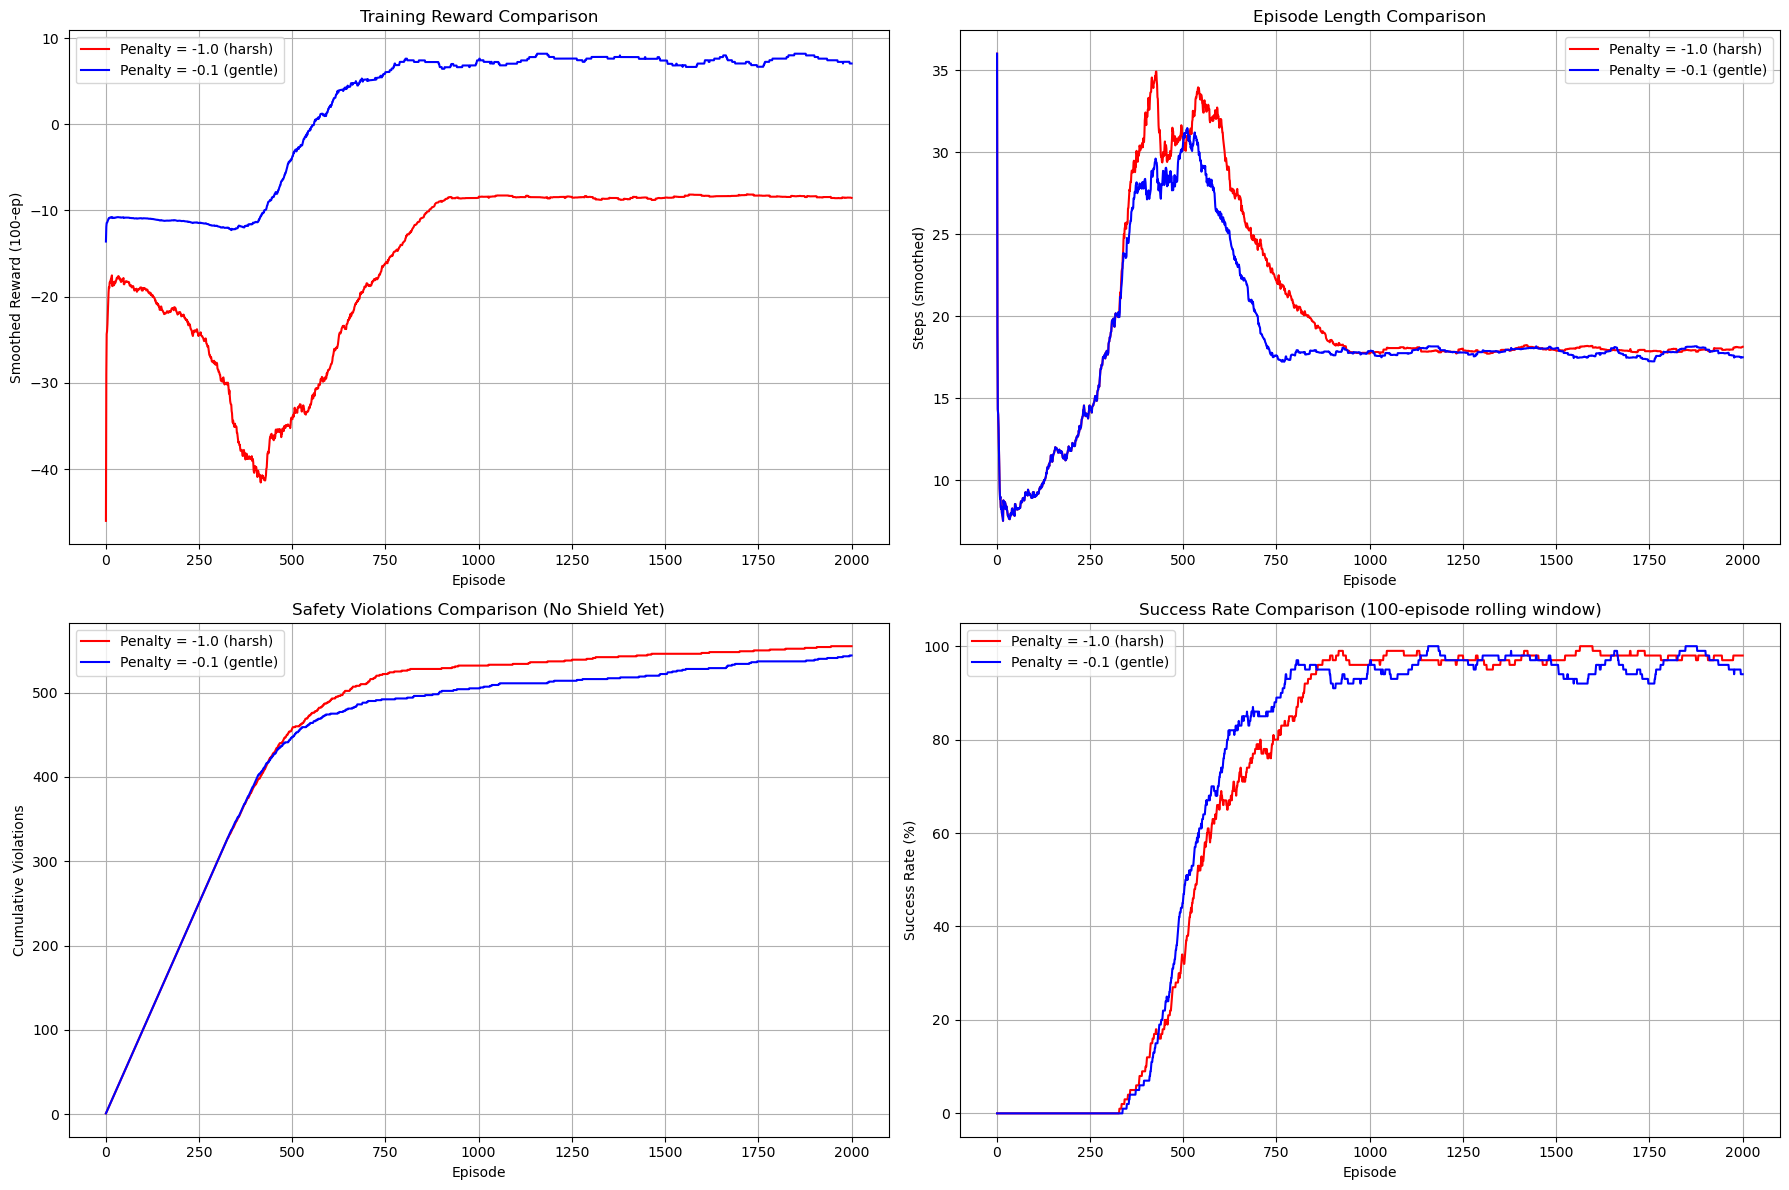

Saved metrics table to qlearning_metrics_comparison.csv
   config     N    M  success_rate_pct  avg_reward  avg_length  \
0   harsh  2000  500              98.2     -8.3560      17.996   
1  gentle  2000  500              95.6      7.3506      17.694   

   total_violations  training_speed_eps_per_sec  training_time_sec  
0               555                16588.537969           0.120565  
1               544                23891.748716           0.083711  
Better config by success rate: harsh (penalty=-1.0)
Saved best Q-table to qtable_best.pkl and metrics_best.pkl


In [22]:
"""
Q-Learning Baseline for Safe Grid World (Task 2)
Run this script to train and evaluate a tabular Q-learning agent with two step-penalty configs:
 - config A: step_penalty = -1.0
 - config B: step_penalty = -0.1

Produces:
 - plots: only displays a single comparison figure.
 - pickles: q_table_best.pkl, metrics_best.pkl (for better performing config by success rate)
"""


# -------------------------
# Q-Learning Implementation
# -------------------------
def state_to_index(state: Tuple[int,int], grid_size=10) -> int:
    return state[0] * grid_size + state[1]

def index_to_state(idx: int, grid_size=10) -> Tuple[int,int]:
    return divmod(idx, grid_size)

def train_q_learning(env: SafeGridWorld,
                     episodes: int = 2000,
                     max_steps: int = 200,
                     alpha: float = 0.1,
                     gamma: float = 0.99,
                     eps_start: float = 1.0,
                     eps_min: float = 0.01,
                     eps_decay: float = 0.995,
                     seed: Optional[int] = None):
    rng = random.Random(seed)
    n_states = env.grid_size * env.grid_size
    n_actions = 4
    Q = np.zeros((n_states, n_actions), dtype=np.float32)

    eps = eps_start

    episode_rewards = np.zeros(episodes, dtype=np.float32)
    episode_lengths = np.zeros(episodes, dtype=np.int32)
    episode_violations = np.zeros(episodes, dtype=np.int32)  # 1 if hazard entered
    episode_success = np.zeros(episodes, dtype=np.int32)     # 1 if reached goal

    t_start = time.time()
    for ep in range(episodes):
        state = env.reset()
        s_idx = state_to_index(state, env.grid_size)
        total_reward = 0.0
        done = False

        for step in range(max_steps):
            # epsilon-greedy
            if rng.random() < eps:
                a = rng.randrange(n_actions)
            else:
                a = int(np.argmax(Q[s_idx]))

            next_state, r, done, info = env.step(a)
            ns_idx = state_to_index(next_state, env.grid_size)

            # Q update
            best_next = np.max(Q[ns_idx])
            td = r + gamma * best_next - Q[s_idx, a]
            Q[s_idx, a] += alpha * td

            total_reward += r

            if info.get('event') == 'hazard':
                episode_violations[ep] = 1
                break  # episode ends immediately on hazard
            if info.get('event') == 'goal':
                episode_success[ep] = 1
                break

            s_idx = ns_idx

        episode_rewards[ep] = total_reward
        episode_lengths[ep] = step + 1
        # decay epsilon
        eps = max(eps_min, eps * eps_decay)

    t_end = time.time()
    t_total = t_end - t_start
    training_speed = episodes / t_total if t_total > 0 else float('inf')

    results = {
        'Q': Q,
        'episode_rewards': episode_rewards,
        'episode_lengths': episode_lengths,
        'episode_violations': episode_violations,
        'episode_success': episode_success,
        'training_time_sec': t_total,
        'training_speed_eps_per_sec': training_speed,
        'hyperparams': {
            'alpha': alpha,
            'gamma': gamma,
            'eps_start': eps_start,
            'eps_min': eps_min,
            'eps_decay': eps_decay,
            'episodes': episodes,
            'max_steps': max_steps,
            'step_penalty': env.step_penalty,
            'random_start': env.random_start
        }
    }
    return results

# -------------------------
# Metrics and Plots
# -------------------------
def compute_metrics(results: Dict[str,Any]) -> Dict[str,Any]:
    ep = len(results['episode_rewards'])
    N = ep
    M = int(np.floor(0.25 * N))  # last 25%
    start_last = N - M

    rewards = results['episode_rewards']
    lengths = results['episode_lengths']
    violations = results['episode_violations']
    success = results['episode_success']

    # Performance metrics over last M episodes
    success_rate = 100.0 * np.mean(success[start_last:])  # %
    avg_reward = float(np.mean(rewards[start_last:]))
    avg_length = float(np.mean(lengths[start_last:]))

    # Training metrics full training
    total_violations = int(np.sum(violations))
    training_speed = results.get('training_speed_eps_per_sec', None)
    training_time = results.get('training_time_sec', None)

    metrics = {
        'N': N,
        'M': M,
        'success_rate_pct': success_rate,
        'avg_reward': avg_reward,
        'avg_length': avg_length,
        'total_violations': total_violations,
        'training_speed_eps_per_sec': training_speed,
        'training_time_sec': training_time
    }
    return metrics

def rolling_mean(x: np.ndarray, window: int = 100) -> np.ndarray:
    s = pd.Series(x)
    return s.rolling(window=window, min_periods=1).mean().to_numpy()

def plot_comparisons(results_dict: Dict[str, Dict[str,Any]],
                     labels: Dict[str,str],
                     out_prefix: str = "qlearning_comparison"):
    # results_dict: name -> results
    episodes = len(next(iter(results_dict.values()))['episode_rewards'])
    x = np.arange(1, episodes + 1)

    color_map = {
    'harsh': 'red',     # harsher step penalty = 红色
    'gentle': 'blue'    # gentler step penalty = 蓝色
}
    plt.figure(figsize=(18,12))
    # Reward curve
    plt.subplot(2,2,1)
    for key, res in results_dict.items():
        plt.plot(x, rolling_mean(res['episode_rewards'], 100), label=labels[key], color=color_map[key])
    plt.title("Training Reward Comparison")
    plt.xlabel("Episode")
    plt.ylabel("Smoothed Reward (100-ep)")
    plt.legend()
    plt.grid(True)

    # Episode length
    plt.subplot(2,2,2)
    for key, res in results_dict.items():
        plt.plot(x, rolling_mean(res['episode_lengths'], 100), label=labels[key], color=color_map[key])
    plt.title("Episode Length Comparison")
    plt.xlabel("Episode")
    plt.ylabel("Steps (smoothed)")
    plt.legend()
    plt.grid(True)

    # Cumulative safety violations
    plt.subplot(2,2,3)
    for key, res in results_dict.items():
        cum_viol = np.cumsum(res['episode_violations'])
        plt.plot(x, cum_viol, label=labels[key], color=color_map[key])
    plt.title("Safety Violations Comparison (No Shield Yet)")
    plt.xlabel("Episode")
    plt.ylabel("Cumulative Violations")
    plt.legend()
    plt.grid(True)

    # Success rate (100-episode rolling window)
    plt.subplot(2,2,4)
    for key, res in results_dict.items():
        success_rate_window = pd.Series(res['episode_success']).rolling(window=100, min_periods=1).mean() * 100.0
        plt.plot(x, success_rate_window, label=labels[key], color=color_map[key])
    plt.title("Success Rate Comparison (100-episode rolling window)")
    plt.xlabel("Episode")
    plt.ylabel("Success Rate (%)")
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    png_file = f"{out_prefix}.png"
    plt.savefig(png_file, dpi=200)
    print(f"Saved comparison figure to {png_file}")
    plt.show()

# -------------------------
# Main experiment runner
# -------------------------
def run_experiments():
    # Hyperparameters from Table 1 (baseline)
    alpha = 0.1
    gamma = 0.99
    eps_start = 1.0
    eps_min = 0.01
    eps_decay = 0.995
    episodes = 2000
    max_steps = 200
    seed = 42

    penalties = {'harsh': -1.0, 'gentle': -0.1}
    all_results = {}
    all_metrics = {}

    for name, pen in penalties.items():
        print(f"\n--- Training Q-learning (penalty={pen}) ---")
        env = SafeGridWorld(step_penalty=pen, random_start=False, seed=seed)
        res = train_q_learning(env,
                               episodes=episodes,
                               max_steps=max_steps,
                               alpha=alpha,
                               gamma=gamma,
                               eps_start=eps_start,
                               eps_min=eps_min,
                               eps_decay=eps_decay,
                               seed=seed)
        metrics = compute_metrics(res)
        print(f"Metrics for penalty {pen}:")
        for k,v in metrics.items():
            print(f"  {k}: {v}")
        all_results[name] = res
        all_metrics[name] = metrics

    # Plot comparisons
    labels = {'harsh': 'Penalty = -1.0 (harsh)', 'gentle': 'Penalty = -0.1 (gentle)'}
    plot_comparisons(all_results, labels, out_prefix="qlearning_penalty_comparison")

    # Save comparison metrics CSV
    df_rows = []
    for k, m in all_metrics.items():
        row = {'config': k}
        row.update(m)
        df_rows.append(row)
    df = pd.DataFrame(df_rows)
    csv_file = "qlearning_metrics_comparison.csv"
    df.to_csv(csv_file, index=False)
    print(f"Saved metrics table to {csv_file}")
    print(df)

    # Choose better performing config by success_rate (could choose other metric)
    better = max(all_metrics.items(), key=lambda kv: kv[1]['success_rate_pct'])[0]
    print(f"Better config by success rate: {better} (penalty={penalties[better]})")

    # Save Q-table and metrics of the better-performing config
    best_results = all_results[better]
    best_metrics = all_metrics[better]
    with open("qtable_best.pkl", "wb") as f:
        pickle.dump(best_results['Q'], f)
    with open("metrics_best.pkl", "wb") as f:
        pickle.dump(best_metrics, f)
    print("Saved best Q-table to qtable_best.pkl and metrics_best.pkl")

if __name__ == "__main__":
    run_experiments()